In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
sheet_id = '1MiunF_O8eNWIcfaOA4PVm668RN7FgLNA0a6U4LWf5Bk'
url = 'https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_id}'.format(sheet_id=sheet_id)
df = pd.read_csv(url)

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 31, 2021",291.02,294.00,294.42,290.26,47.00M,-0.76%
1,"Mar 30, 2021",293.25,294.86,295.72,291.50,38.81M,-0.02%
2,"Mar 29, 2021",293.30,289.72,294.09,289.26,43.68M,0.71%
3,"Mar 26, 2021",291.22,288.63,292.75,288.32,56.07M,1.59%
4,"Mar 25, 2021",286.66,286.50,287.03,283.85,35.22M,0.30%


In [4]:
df.shape

(311, 7)

In [5]:
df.isna().any()

,0
Date,False
Price,False
Open,False
High,False
Low,False
Vol.,False
Change %,False


In [6]:
df.dtypes

,0
Date,object
Price,float64
Open,float64
High,float64
Low,float64
Vol.,object
Change %,object


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [8]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00M,-0.76%
2021-03-30,293.25,294.86,295.72,291.50,38.81M,-0.02%
2021-03-29,293.30,289.72,294.09,289.26,43.68M,0.71%
2021-03-26,291.22,288.63,292.75,288.32,56.07M,1.59%
2021-03-25,286.66,286.50,287.03,283.85,35.22M,0.30%


#Exploratory Data Analysis

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
def remove_string(data, column, item):
  data[column] = df[column].str.replace(item, '').astype(float)
  return data[column].dtype

In [11]:
remove_string(df, 'Change %', '%')
remove_string(df, 'Vol.', 'M')


dtype('float64')

In [12]:
df.head()


,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2021-03-31,291.02,294.00,294.42,290.26,47.00,-0.76
2021-03-30,293.25,294.86,295.72,291.50,38.81,-0.02
2021-03-29,293.30,289.72,294.09,289.26,43.68,0.71
2021-03-26,291.22,288.63,292.75,288.32,56.07,1.59
2021-03-25,286.66,286.50,287.03,283.85,35.22,0.30


In [13]:
y = df['Price']

In [14]:
type(y)

pandas.core.series.Series

In [15]:

y.describe()

,Price
count,311.000000
mean,234.524019
std,32.079847
min,174.270000
25%,207.700000
50%,229.140000
75%,264.380000
max,293.300000


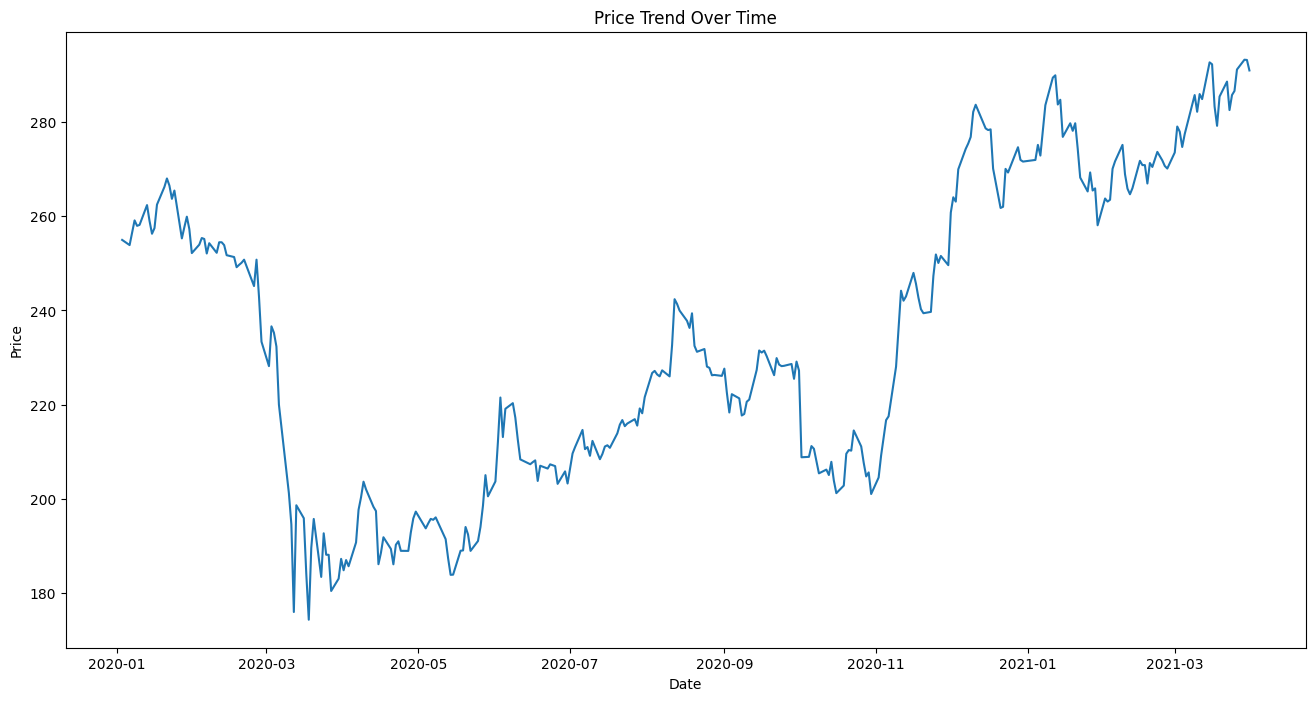

In [16]:
plt.figure(figsize=(16, 8))
plt.plot(y)
plt.title('Price Trend Over Time')  # Add a descriptive title
plt.xlabel('Date')  # Add label for x-axis
plt.ylabel('Price')  # Add label for y-axis
plt.show()


In [17]:
decomp = seasonal_decompose(df['Price'], model='additive', period=90)
seasonal = decomp.seasonal
trend = decomp.trend
residual = decomp.resid

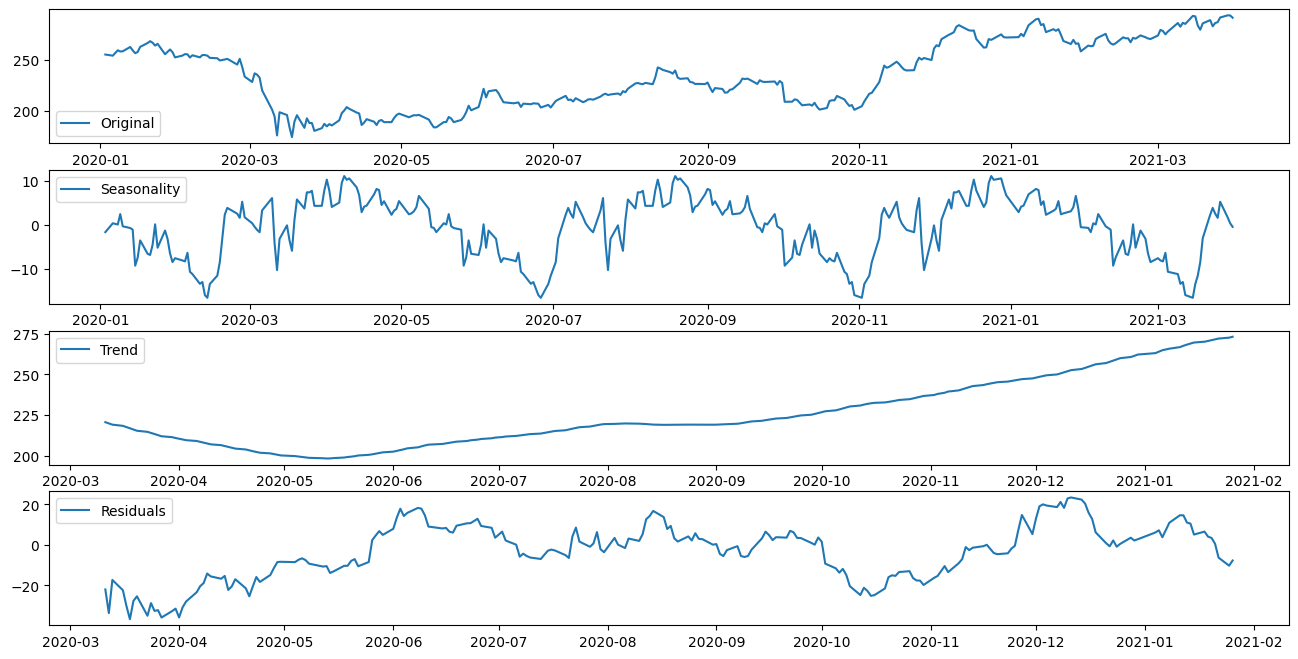

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(df['Price'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.show()

#Testing For Stationarity

In [19]:
from statsmodels.tsa.stattools import kpss
kpss_stat, p_value, n_lags, critical_value = kpss(df['Price'])
def stationarity_check(value):
    if value < 0.05:
        print("Data is not stationary")
    else:
        print("Data is stationary")
stationarity_check(p_value)

Data is not stationary


<ipython-input-19-f210059bdee2>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, n_lags, critical_value = kpss(df['Price'])


In [20]:
df['price_diff'] = df['Price'].diff()
df = df.dropna()

In [21]:
df['rolling_mean_diff'] = df['price_diff'].rolling(window=5).mean()
df = df.dropna()

In [22]:

df.head()


,Price,Open,High,Low,Vol.,Change %,price_diff,rolling_mean_diff
Date,,,,,,,,
2021-03-24,285.79,283.40,288.00,282.25,46.41,1.13,-0.87,-1.046
2021-03-23,282.60,287.56,288.30,282.11,70.76,-2.10,-3.19,-2.130
2021-03-22,288.65,285.00,291.20,283.08,62.76,1.11,6.05,-0.930
2021-03-19,285.47,279.00,286.31,278.03,84.25,2.23,-3.18,-1.150
2021-03-18,279.25,284.04,285.79,278.24,74.13,-1.45,-6.22,-1.482


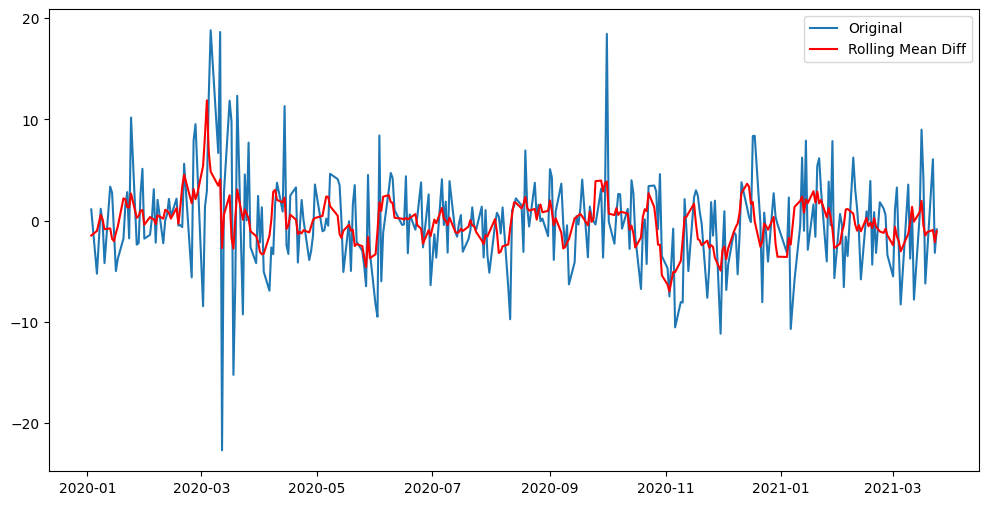

In [23]:
plt.figure(figsize=(12,6))
plt.plot(df['price_diff'], label='Original')
plt.plot(df['rolling_mean_diff'], color='red', label='Rolling Mean Diff')
plt.legend()
plt.show()

In [24]:
stationarity_check(kpss(df['rolling_mean_diff'])[1])

Data is stationary


In [25]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [26]:
# Ensure the index is sorted
df = df.sort_index()


In [27]:
df_train = df.loc['2020-01-01':'2021-01-01']
df_test = df.loc['2021-01-01':]

#Creating The ARIMA Model

In [28]:
def evaluate_arima_model(data, arima_order):
  train = data.loc['2020-01-01':'2021-01-01']['rolling_mean_diff'].values
  test = data.loc['2021-01-01':]['rolling_mean_diff'].values
  history = [x for x in train]
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit()
    future = model_fit.forecast()[0]
    predictions.append(future)
    history.append(test[t])
  error = mean_squared_error(test, predictions)
  return error

In [29]:
#statistical model
#plot prediction on top of time series
#after Arima use Arimax and Sarima and prophet model from facebook and LSTM to make predictions

#Finding The Right ARIMA Order For The Model

In [30]:
def evaluate_model(data, p_values, d_values, q_values):
  best_score, best_cfg = float("inf"), None
  for p in p_values:
    for d in d_values:
      for q in q_values:
        order = (p,d,q)
        try:
          mse = evaluate_arima_model(data, order)
          if mse < best_score:
            best_score, best_cfg = mse, order
          print('ARIMA%s MSE=%.3f' % (order,mse))
        except:
          continue
  return print("Best ARIMA%s MSE=%.3f" % (best_cfg, best_score))


In [31]:
p_values = [x for x in range(0, 5)]
d_values = [x for x in range(0, 5)]
q_values = [x for x in range(0, 5)]


In [32]:
evaluate_model(df_train['rolling_mean_diff'], p_values, d_values, q_values)

Best ARIMANone MSE=inf


In [33]:
p = 1
d = 2
q = 1
model = ARIMA(df_train['rolling_mean_diff'], order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(df_test))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#Plotting The Fitted Model

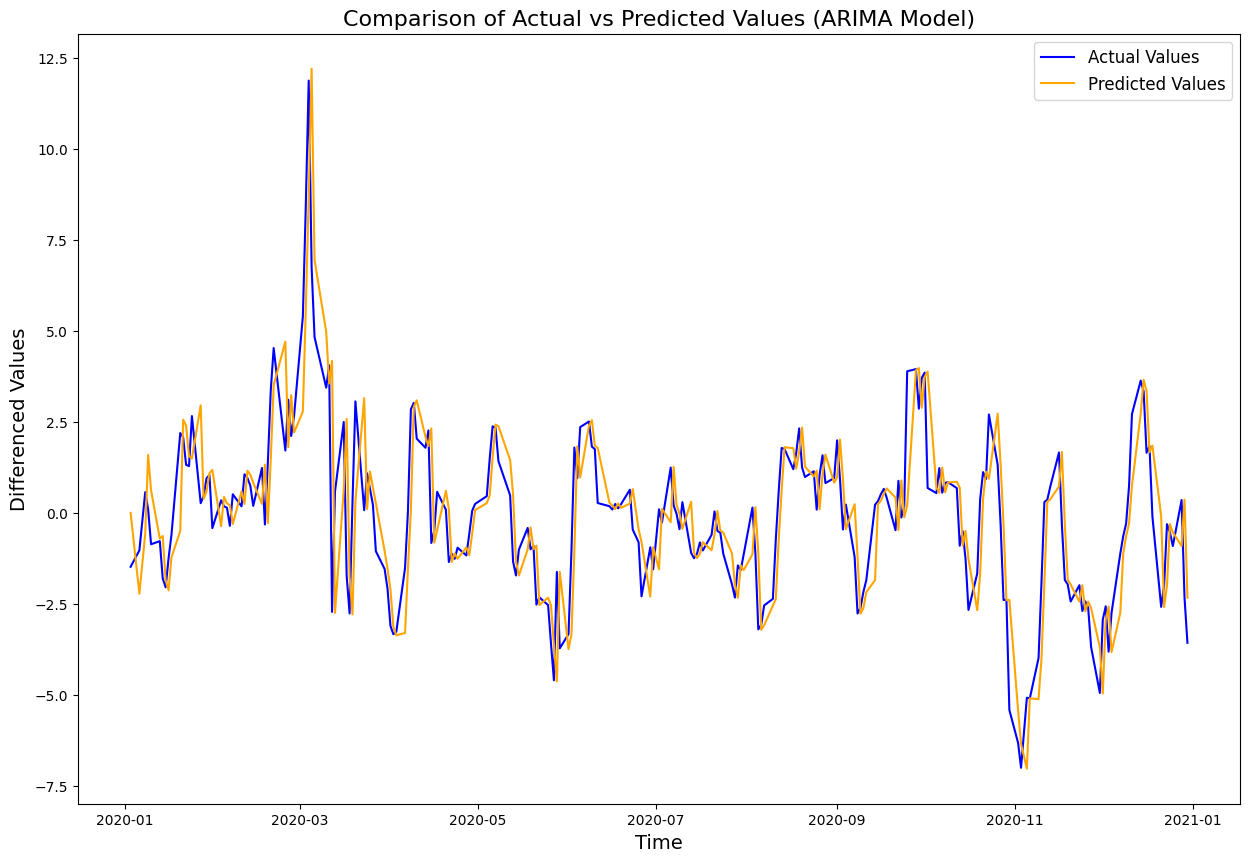

In [34]:
plt.figure(figsize=(15, 10))

# Plot the actual values
plt.plot(df_train['rolling_mean_diff'], label='Actual Values', color='blue')

# Plot the ARIMA model's predictions
plt.plot(model_fit.predict(), label='Predicted Values', color='orange')

# Add title and labels
plt.title('Comparison of Actual vs Predicted Values (ARIMA Model)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


#Plotting The Forecast

In [35]:
future_cast = model_fit.forecast(len(df_test))
future_cast.index = df_test.index
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


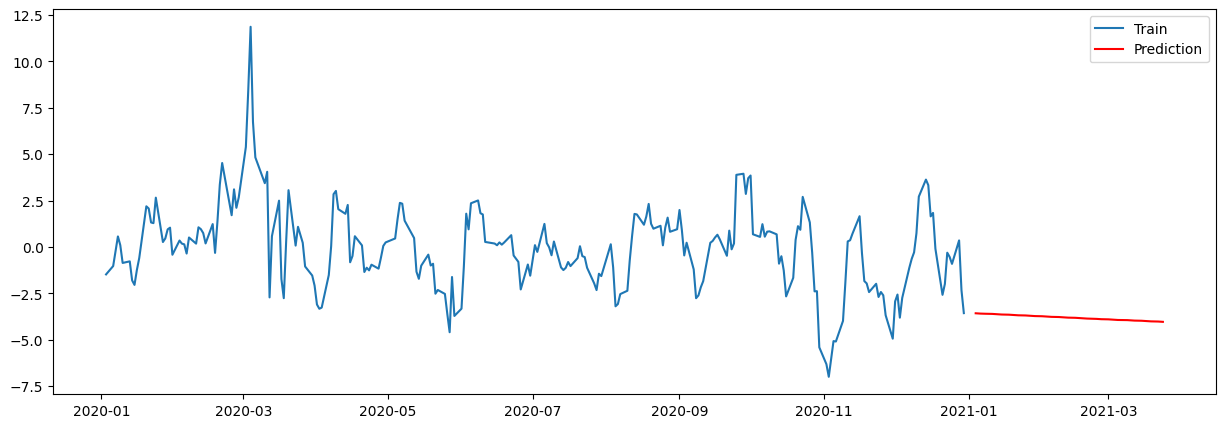

In [36]:
plt.figure(figsize=(15, 5))
plt.plot(df_train['rolling_mean_diff'], label='Train')
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')
plt.legend()
plt.show()

#Back Testing The Model


In [37]:
def evaluate_arima_model(data, arima_order, start_train_size):
    history = list(data[:start_train_size])
    predictions = []
    for t in range(start_train_size, len(data)):

        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(7)[-1]
        predictions.append(future)
        history.append(data[t])
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse , mae, predictions


In [38]:
mse, mae, predictions = evaluate_arima_model(df['rolling_mean_diff'].sort_index(), (1, 2, 1), len(df_train))

#Plotting The Forecast With Bollinger Bands

In [39]:
forecast = pd.DataFrame(predictions)
forecast.columns = ['rolling_mean_diff']
forecast.index = df_test.index[::-1]
forecast.head()

,rolling_mean_diff
Date,
2021-03-24,-3.626643
2021-03-23,-3.657335
2021-03-22,-1.722661
2021-03-19,-2.395069
2021-03-18,1.397644


In [40]:

f_std = forecast['rolling_mean_diff'].std()

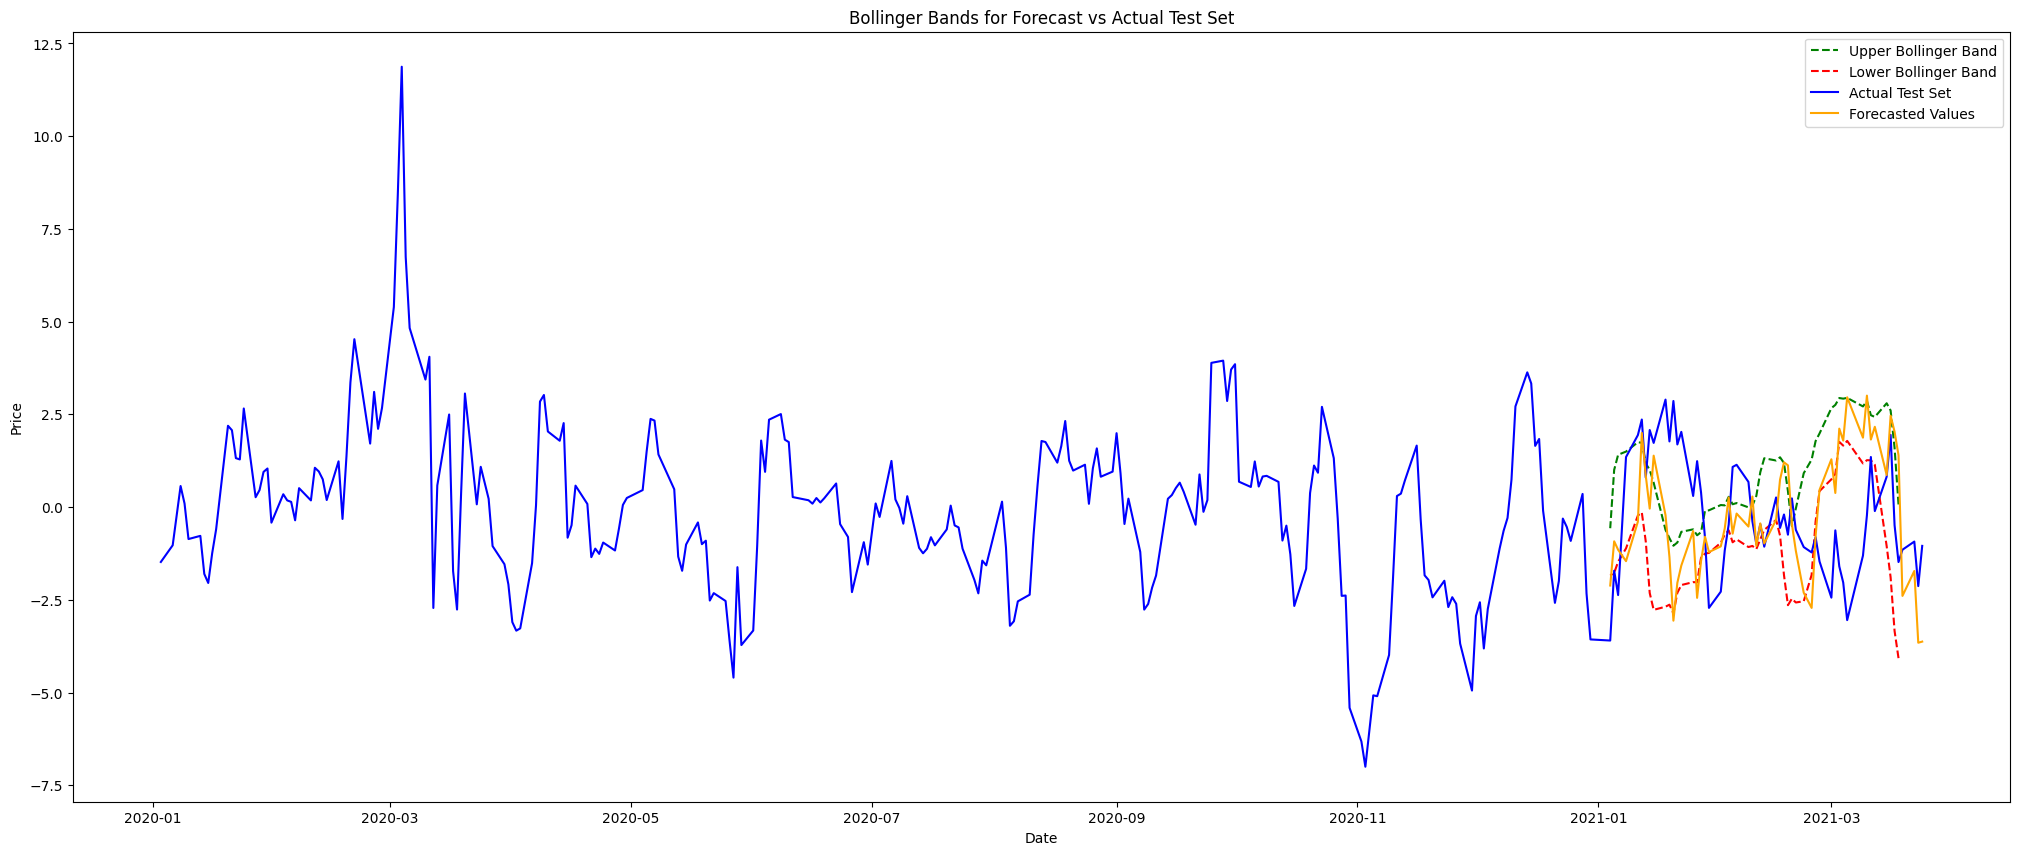

In [41]:
# Calculate Bollinger Bands for the forecast
window = 5  # Rolling window size for Bollinger Bands
forecast['SMA'] = forecast['rolling_mean_diff'].rolling(window=window).mean()
forecast['Rolling_STD'] = forecast['rolling_mean_diff'].rolling(window=window).std()

# Upper and Lower Bands
forecast['Upper_Band'] = forecast['SMA'] + (forecast['Rolling_STD'])
forecast['Lower_Band'] = forecast['SMA'] - (forecast['Rolling_STD'])

# Plotting Bollinger Bands for the forecast
plt.figure(figsize=(25, 10))

# Upper and Lower Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Actual test set
plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

# Forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Title and labels
plt.title('Bollinger Bands for Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#Decisions: Buy, Hold, Sell?

            rolling_mean_diff  Upper_Band  Lower_Band Decision
Date                                                          
2021-03-24          -3.626643         NaN         NaN     Hold
2021-03-23          -3.657335         NaN         NaN     Hold
2021-03-22          -1.722661         NaN         NaN     Hold
2021-03-19          -2.395069         NaN         NaN     Hold
2021-03-18           1.397644    0.071004   -4.072630     Sell
2021-03-17           2.032429    1.600232   -3.338229     Sell
2021-03-16           2.464328    2.604206   -1.893537     Hold
2021-03-15           0.864302    2.798357   -1.052903     Hold
2021-03-12           2.164657    2.429764    1.139580     Hold
2021-03-11           1.820242    2.477536    1.260847     Hold
2021-03-10           3.004919    2.862817    1.264563     Sell
2021-03-09           1.871503    2.713329    1.176920     Hold
2021-03-05           2.960380    2.944084    1.784597     Sell
2021-03-04           1.792863    2.923124    1.656840  

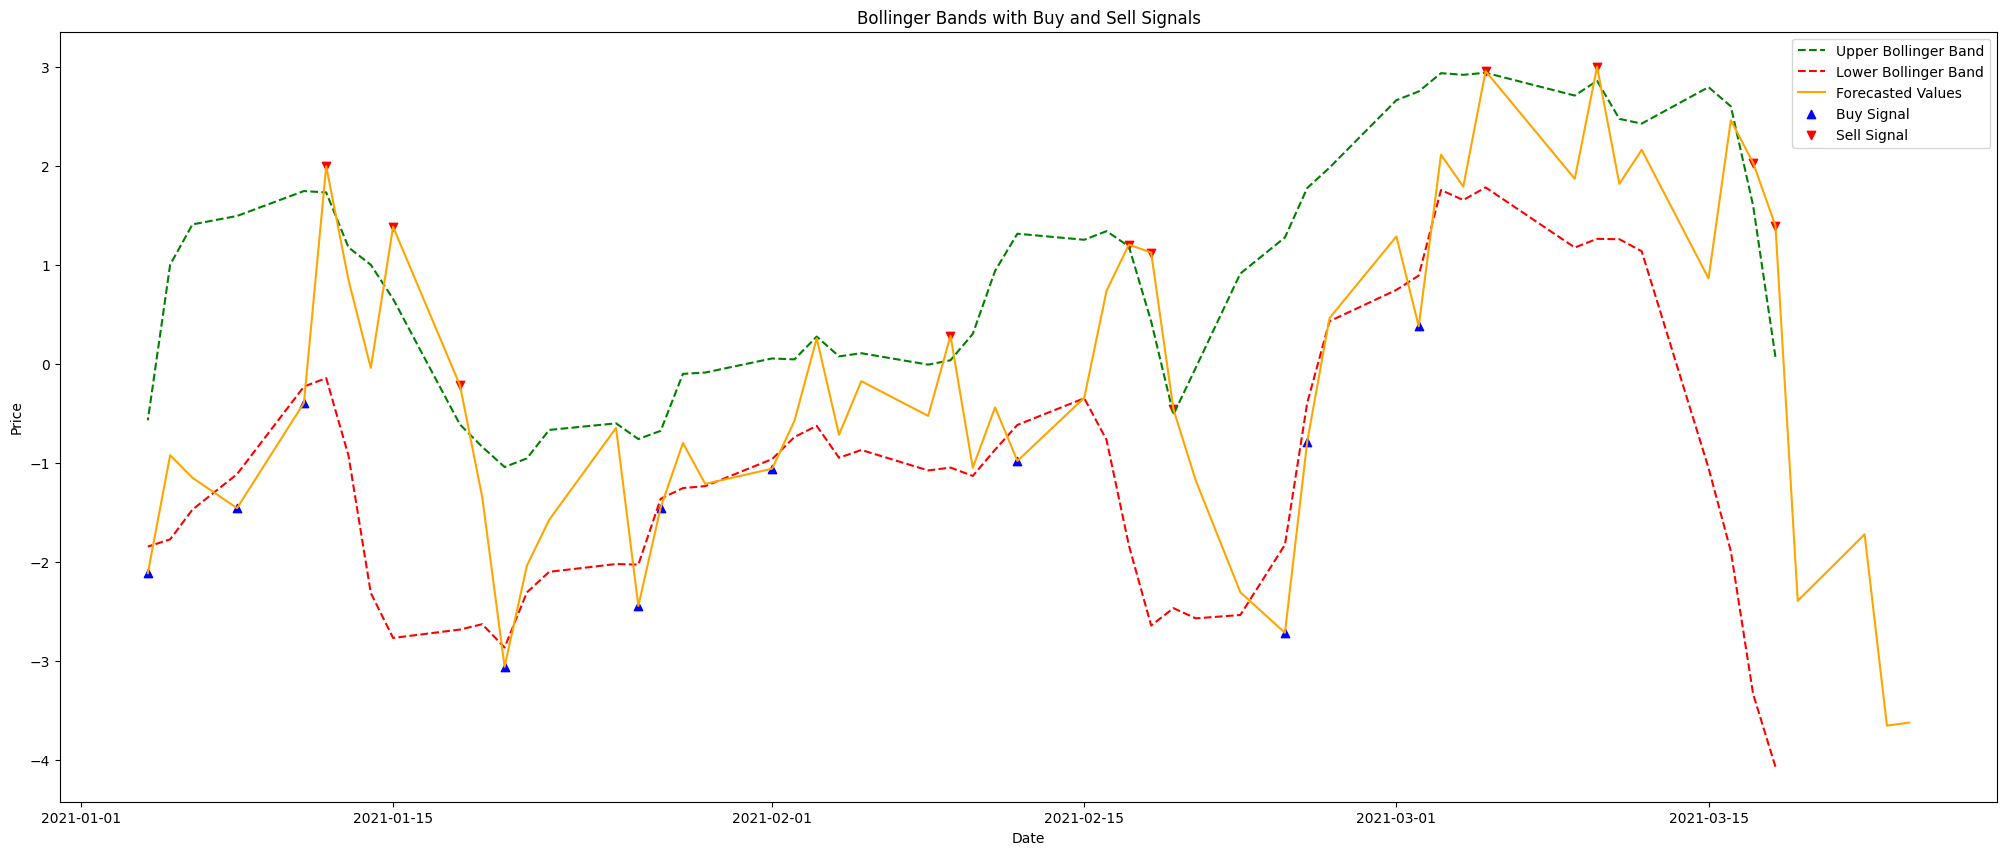

In [42]:
# Create a decision column
forecast['Decision'] = 'Hold'

# Set Buy, Sell, or Hold based on Bollinger Bands
for i in range(len(forecast)):
    if forecast['rolling_mean_diff'].iloc[i] < forecast['Lower_Band'].iloc[i]:
        forecast['Decision'].iloc[i] = 'Buy'
    elif forecast['rolling_mean_diff'].iloc[i] > forecast['Upper_Band'].iloc[i]:
        forecast['Decision'].iloc[i] = 'Sell'
    else:
        forecast['Decision'].iloc[i] = 'Hold'

# Display the last few rows with decisions
print(forecast[['rolling_mean_diff', 'Upper_Band', 'Lower_Band', 'Decision']])

# Plotting decisions
plt.figure(figsize=(25, 10))

# Plot Bollinger Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Highlight Buy and Sell points
buy_signals = forecast[forecast['Decision'] == 'Buy']
sell_signals = forecast[forecast['Decision'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['rolling_mean_diff'], label='Buy Signal', color='blue', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['rolling_mean_diff'], label='Sell Signal', color='red', marker='v', alpha=1)

# Title and labels
plt.title('Bollinger Bands with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#Creating The ARIMAX Model

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

def evaluate_arimax_model(data, arima_order, exog_train, exog_test):
    # Train and Test sets for the dependent variable
    train = data.loc['2020-01-01':'2021-01-01']['rolling_mean_diff'].values
    test = data.loc['2021-01-01':]['rolling_mean_diff'].values

    # Exogenous variables
    exog_train = exog_train.loc['2020-01-01':'2021-01-01'].values
    exog_test = exog_test.loc['2021-01-01':].values

    # Initialize the history with the train set
    history = [x for x in train]
    exog_history = [x for x in exog_train]

    # Store predictions
    predictions = list()

    # Loop through the test set
    for t in range(len(test)):
        # Fit the ARIMAX model
        model = SARIMAX(history, exog=exog_history, order=arima_order)
        model_fit = model.fit(disp=False)

        # Forecast the next value using the current test exogenous variable
        future = model_fit.forecast(steps=1, exog=exog_test[t].reshape(1, -1))[0]
        predictions.append(future)

        # Append the actual observed value and exogenous variable to history
        history.append(test[t])
        exog_history.append(exog_test[t])

    # Calculate Mean Squared Error
    error = mean_squared_error(test, predictions)

    return error, predictions


In [46]:
def evaluate_arimax_model(data, arima_order):
    train = data.loc['2020-01-01':'2021-01-01']['rolling_mean_diff'].values
    test = data.loc['2021-01-01':]['rolling_mean_diff'].values
    exog_train = data.loc['2020-01-01':'2021-01-01']['Vol.'].values  # Replace 'Vol.' with the desired exogenous variable
    exog_test = data.loc['2021-01-01':]['Vol.'].values  # Same here

    history = [x for x in train]
    exog_history = [x for x in exog_train]
    predictions = list()

    for t in range(len(test)):
        model = ARIMA(history, exog=exog_history, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast(exog=[exog_test[t]])[0]
        predictions.append(future)
        history.append(test[t])
        exog_history.append(exog_test[t])

    error = mean_squared_error(test, predictions)
    return error


In [45]:
print(df.columns)


Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'price_diff',
       'rolling_mean_diff'],
      dtype='object')


In [47]:
# Define the ARIMAX order
p = 1
d = 2
q = 1

# Define the exogenous variables for training and testing
exog_train = df_train['Vol.']  # Replace 'Vol.' with your desired exogenous variable
exog_test = df_test['Vol.']   # Same column for the testing set

# Create the ARIMAX model
model = ARIMA(df_train['rolling_mean_diff'], exog=exog_train, order=(p, d, q))

# Fit the ARIMAX model
model_fit = model.fit()

# Forecast using the ARIMAX model
forecast = model_fit.forecast(steps=len(df_test), exog=exog_test)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


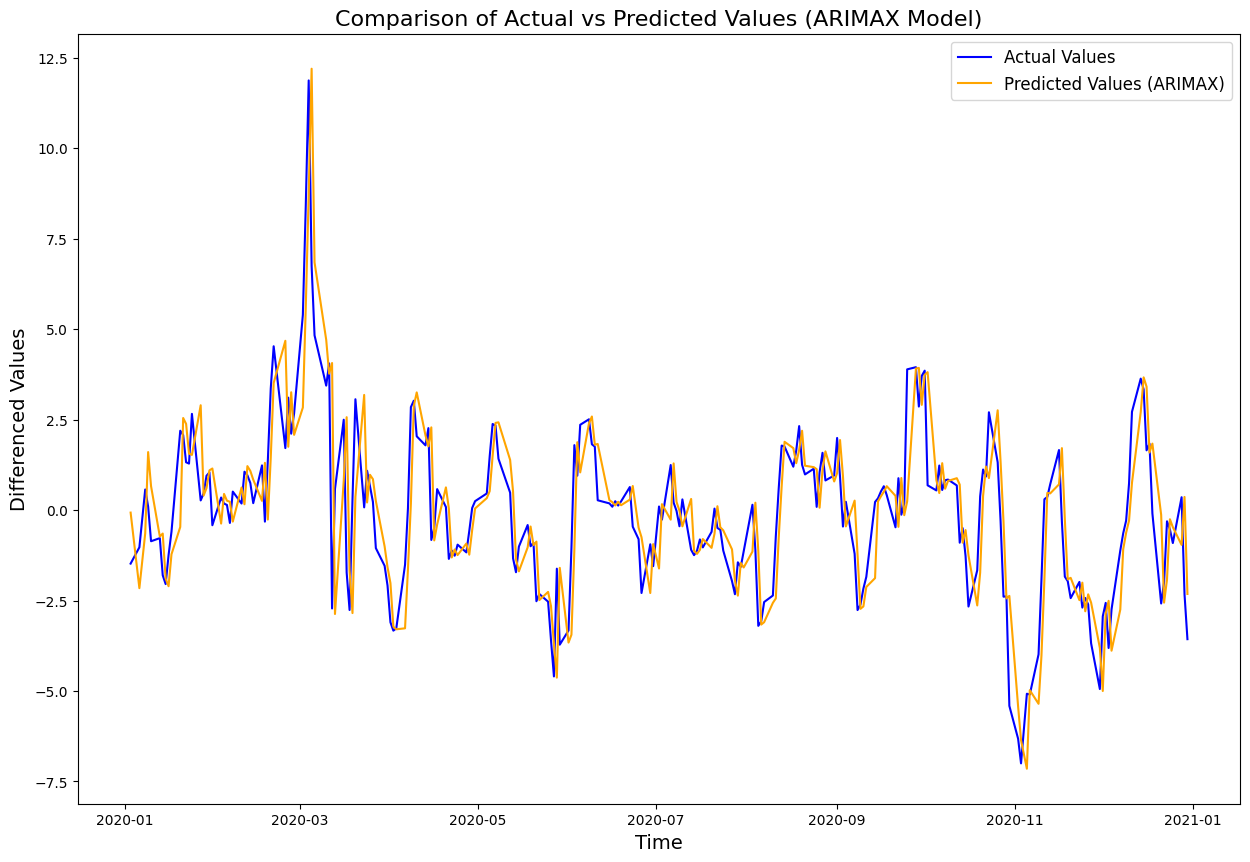

In [48]:
plt.figure(figsize=(15, 10))

# Plot the actual values
plt.plot(df_train['rolling_mean_diff'], label='Actual Values', color='blue')

# Plot the ARIMAX model's predictions
arimax_predictions = model_fit.predict(exog=exog_train)
plt.plot(arimax_predictions, label='Predicted Values (ARIMAX)', color='orange')

# Add title and labels
plt.title('Comparison of Actual vs Predicted Values (ARIMAX Model)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


In [49]:
future_cast = model_fit.forecast(steps=len(df_test), exog=exog_test)  # Include the exogenous variable
future_cast = pd.DataFrame(future_cast)
future_cast.index = df_test.index
future_cast.columns = ['rolling_mean_diff']

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


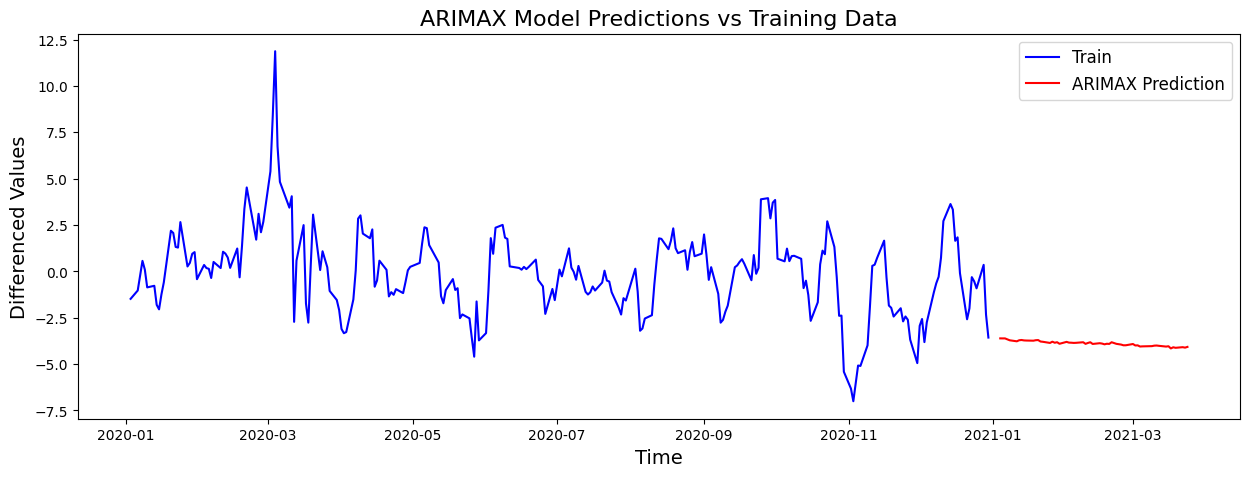

In [51]:
plt.figure(figsize=(15, 5))

# Plot the training data
plt.plot(df_train['rolling_mean_diff'], label='Train', color='blue')

# Plot the ARIMAX model's predictions
plt.plot(future_cast['rolling_mean_diff'], color='red', label='ARIMAX Prediction')

# Add labels, title, and legend
plt.title('ARIMAX Model Predictions vs Training Data', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)
plt.legend(fontsize=12)

# Show the plot
plt.show()


In [52]:
def evaluate_arimax_model(data, exog_data, arima_order, start_train_size):
    """
    Evaluate an ARIMAX model using a rolling forecast approach.

    Parameters:
    - data: The target time series data (dependent variable).
    - exog_data: The exogenous variable(s) data.
    - arima_order: The (p, d, q) order of the ARIMAX model.
    - start_train_size: The initial training set size.

    Returns:
    - mse: Mean Squared Error of the predictions.
    - mae: Mean Absolute Error of the predictions.
    - predictions: List of predicted values.
    """
    # Split the exogenous data into train and test
    exog_train = exog_data[:start_train_size]
    exog_test = exog_data[start_train_size:]

    # Initialize the history with the training data
    history = list(data[:start_train_size])
    history_exog = list(exog_train)

    predictions = []

    for t in range(len(exog_test)):
        # Train the ARIMAX model
        model = ARIMA(history, order=arima_order, exog=history_exog)
        model_fit = model.fit()

        # Forecast the next step
        future = model_fit.forecast(steps=1, exog=[exog_test[t]])[0]
        predictions.append(future)

        # Append the true value and the exogenous variable for the next iteration
        history.append(data[start_train_size + t])
        history_exog.append(exog_test[t])

    # Calculate error metrics
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse, mae, predictions


In [57]:
print(df.columns)

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'price_diff',
       'rolling_mean_diff'],
      dtype='object')


In [58]:
# Example: Creating an exogenous variable
df['exog_variable'] = df['Open'] + df['High']  # Replace with your logic

In [59]:
mse, mae, predictions = evaluate_arimax_model(
    df['rolling_mean_diff'].sort_index(),  # Target variable
    df['exog_variable'].sort_index(),     # Exogenous variable (use correct name)
    (1, 2, 1),                            # ARIMAX order (p, d, q)
    len(df_train)                         # Training data size
)


In [60]:
# Create a DataFrame for predictions
forecast = pd.DataFrame(predictions, columns=['rolling_mean_diff'])

# Align the forecast index with the test data index
forecast.index = df_test.index

# Preview the forecast
forecast.head()


,rolling_mean_diff
Date,
2021-01-04,-3.211450
2021-01-05,-3.842644
2021-01-06,-1.812661
2021-01-08,-1.793533
2021-01-11,2.039752


In [61]:
f_std = forecast['rolling_mean_diff'].std()

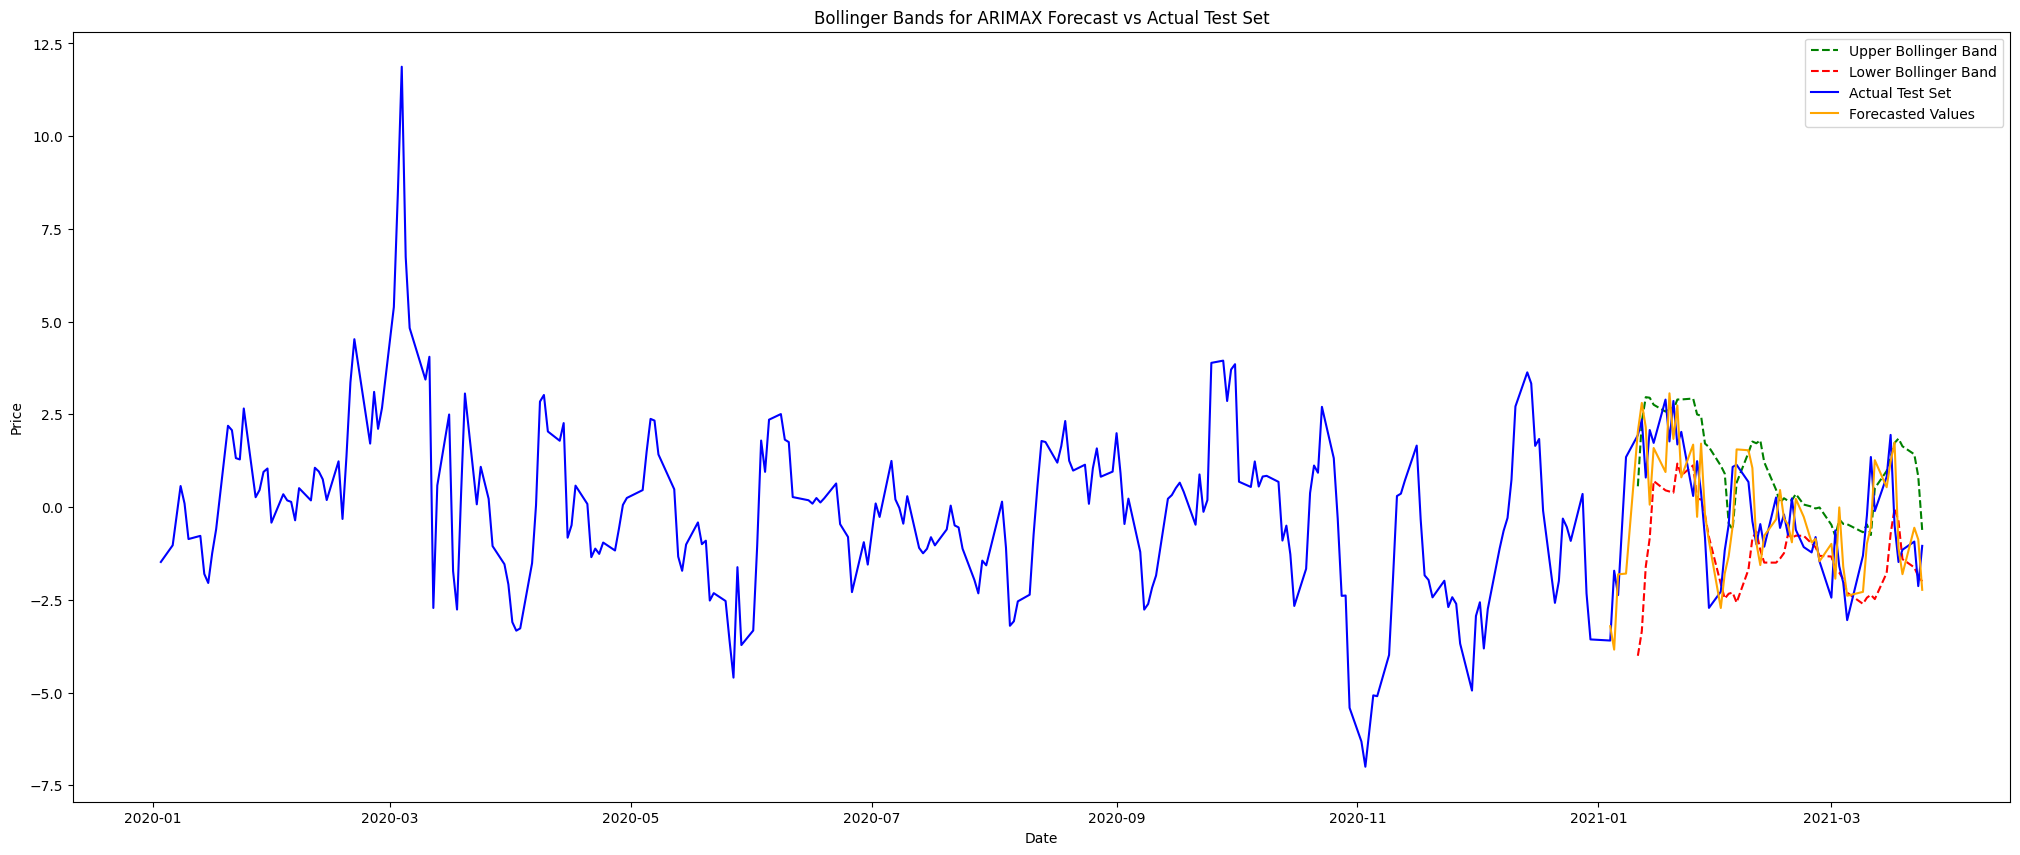

In [62]:
# Calculate Bollinger Bands for the ARIMAX forecast
window = 5  # Rolling window size for Bollinger Bands

# Ensure forecast contains 'rolling_mean_diff' from ARIMAX predictions
forecast['SMA'] = forecast['rolling_mean_diff'].rolling(window=window).mean()
forecast['Rolling_STD'] = forecast['rolling_mean_diff'].rolling(window=window).std()

# Calculate Upper and Lower Bollinger Bands
forecast['Upper_Band'] = forecast['SMA'] + forecast['Rolling_STD']
forecast['Lower_Band'] = forecast['SMA'] - forecast['Rolling_STD']

# Plotting Bollinger Bands for the ARIMAX forecast
plt.figure(figsize=(25, 10))

# Plot Upper and Lower Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot Actual Test Set
plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

# Plot Forecasted Values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Add Title and Labels
plt.title('Bollinger Bands for ARIMAX Forecast vs Actual Test Set')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Display Plot
plt.show()


            rolling_mean_diff  Upper_Band  Lower_Band Decision
Date                                                          
2021-03-18          -1.109847    1.846730   -0.383886      Buy
2021-03-19          -1.809162    1.638231   -1.404531      Buy
2021-03-22          -0.557097    1.423049   -1.626336     Hold
2021-03-23          -0.873422    0.823752   -1.867596     Hold
2021-03-24          -2.230760   -0.627889   -2.004226      Buy


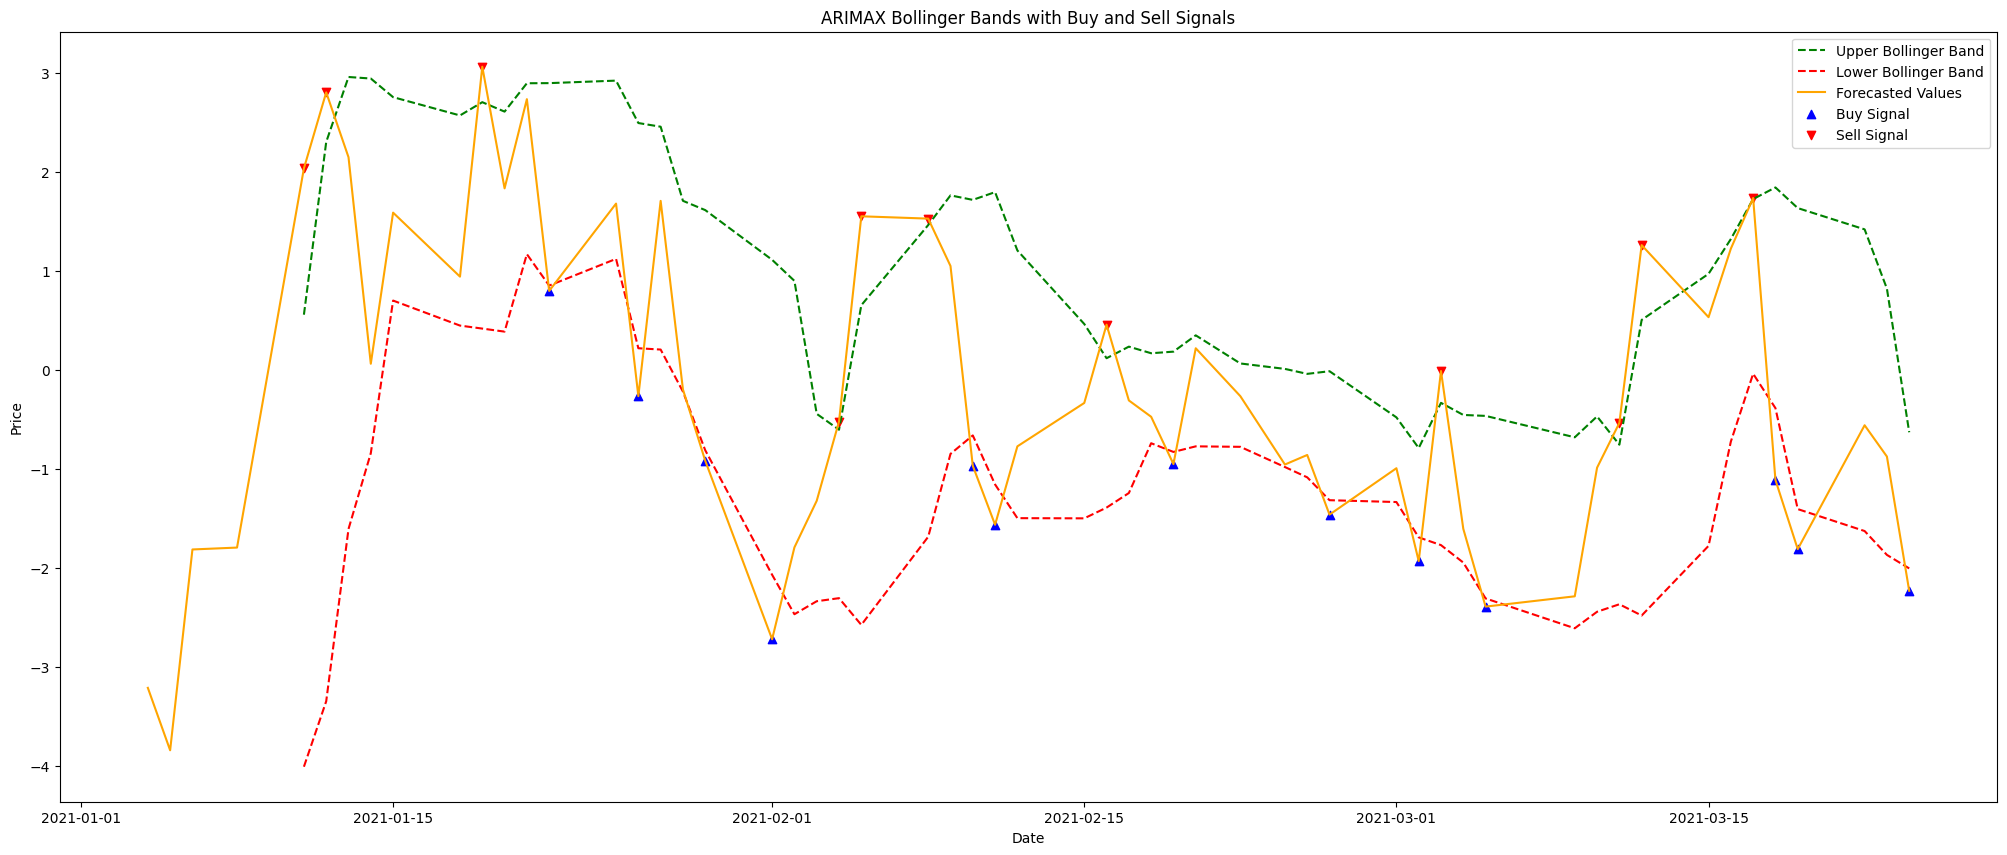

In [63]:
# Ensure forecast contains predictions from ARIMAX
forecast['Decision'] = 'Hold'  # Initialize the decision column

# Set Buy, Sell, or Hold based on Bollinger Bands
for i in range(len(forecast)):
    if forecast['rolling_mean_diff'].iloc[i] < forecast['Lower_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Buy'
    elif forecast['rolling_mean_diff'].iloc[i] > forecast['Upper_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Sell'
    else:
        forecast.loc[forecast.index[i], 'Decision'] = 'Hold'

# Display the last few rows with decisions
print(forecast[['rolling_mean_diff', 'Upper_Band', 'Lower_Band', 'Decision']].tail())

# Plotting decisions
plt.figure(figsize=(25, 10))

# Plot Bollinger Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values', color='orange')

# Highlight Buy and Sell points
buy_signals = forecast[forecast['Decision'] == 'Buy']
sell_signals = forecast[forecast['Decision'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['rolling_mean_diff'], label='Buy Signal', color='blue', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['rolling_mean_diff'], label='Sell Signal', color='red', marker='v', alpha=1)

# Title and labels
plt.title('ARIMAX Bollinger Bands with Buy and Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


#Creating The SARIMA Model

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

def evaluate_sarima_model(data, arima_order, seasonal_order):
    """
    Evaluate SARIMA model by splitting data into train and test sets and computing prediction errors.

    Parameters:
    - data: DataFrame containing the time series data
    - arima_order: Tuple specifying (p, d, q) for ARIMA
    - seasonal_order: Tuple specifying (P, D, Q, m) for SARIMA

    Returns:
    - error: Mean squared error of the predictions
    """
    train = data.loc['2020-01-01':'2021-01-01']['rolling_mean_diff'].values
    test = data.loc['2021-01-01':]['rolling_mean_diff'].values
    history = [x for x in train]
    predictions = []

    for t in range(len(test)):
        # Fit SARIMA model
        model = SARIMAX(history, order=arima_order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        # Forecast next value
        future = model_fit.forecast(steps=1)[0]
        predictions.append(future)
        # Append actual value to history for the next iteration
        history.append(test[t])

    # Compute the mean squared error
    error = mean_squared_error(test, predictions)
    return error


In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

def evaluate_sarima_model(data, arima_order, seasonal_order):
    """
    Evaluate a SARIMA model with specified order and seasonal_order.
    """
    train = data.loc['2020-01-01':'2021-01-01']['rolling_mean_diff'].values
    test = data.loc['2021-01-01':]['rolling_mean_diff'].values
    history = [x for x in train]
    predictions = []

    for t in range(len(test)):
        # Fit the SARIMA model
        model = SARIMAX(history, order=arima_order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        # Forecast the next value
        future = model_fit.forecast(steps=1)[0]
        predictions.append(future)
        # Add the actual value to the history for the next prediction
        history.append(test[t])

    # Calculate the mean squared error
    mse = mean_squared_error(test, predictions)
    return mse

def evaluate_sarima_model_grid(data, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
    """
    Evaluate multiple SARIMA configurations using grid search.
    """
    best_score, best_cfg, best_seasonal_cfg = float("inf"), None, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            for m in m_values:
                                # Combine ARIMA and seasonal parameters
                                order = (p, d, q)
                                seasonal_order = (P, D, Q, m)
                                try:
                                    mse = evaluate_sarima_model(data, order, seasonal_order)
                                    if mse < best_score:
                                        best_score, best_cfg, best_seasonal_cfg = mse, order, seasonal_order
                                    print(f"SARIMA{order}x{seasonal_order} MSE={mse:.3f}")
                                except Exception as e:
                                    print(f"Failed for SARIMA{order}x{seasonal_order}: {e}")
                                    continue
    print(f"Best SARIMA{best_cfg}x{best_seasonal_cfg} MSE={best_score:.3f}")
    return best_cfg, best_seasonal_cfg


In [66]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the ARIMA and Seasonal parameters
p, d, q = 1, 2, 1  # ARIMA order
P, D, Q, m = 1, 1, 1, 12  # Seasonal order with m=12 for monthly seasonality

# Initialize the SARIMA model
model = SARIMAX(df_train['rolling_mean_diff'], order=(p, d, q), seasonal_order=(P, D, Q, m))

# Fit the model to the training data
model_fit = model.fit()

# Forecast the future values for the length of the test data
forecast = model_fit.forecast(steps=len(df_test))

# Convert forecast results to a DataFrame for easier handling
forecast = pd.DataFrame(forecast, index=df_test.index, columns=['rolling_mean_diff'])

# Display the first few rows of the forecast
print(forecast.head())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


           rolling_mean_diff
Date                        
2021-01-04               NaN
2021-01-05               NaN
2021-01-06               NaN
2021-01-08               NaN
2021-01-11               NaN


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


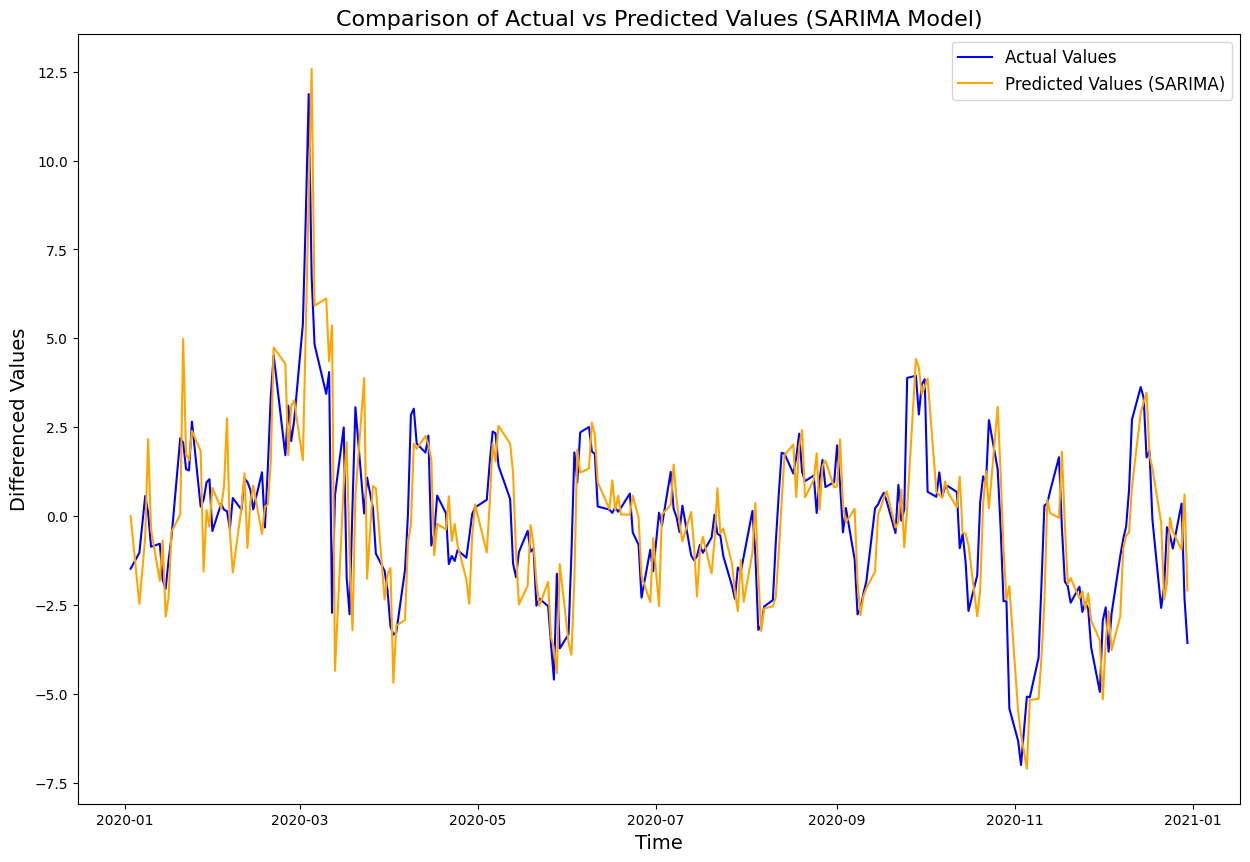

In [67]:
plt.figure(figsize=(15, 10))

# Plot the actual values
plt.plot(df_train['rolling_mean_diff'], label='Actual Values', color='blue')

# Plot the SARIMA model's predictions
predicted_values = model_fit.predict(start=df_train.index[0], end=df_train.index[-1])
plt.plot(predicted_values, label='Predicted Values (SARIMA)', color='orange')

# Add title and labels
plt.title('Comparison of Actual vs Predicted Values (SARIMA Model)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


In [68]:
# Forecasting future values using SARIMA
future_cast = model_fit.get_forecast(steps=len(df_test))  # Use get_forecast for SARIMA
future_ci = future_cast.conf_int()  # Confidence intervals for the forecast
future_cast = future_cast.predicted_mean  # Extract predicted mean values
future_cast.index = df_test.index  # Align forecast index with test data

# Convert to DataFrame for consistency
future_cast = pd.DataFrame(future_cast)
future_cast.columns = ['rolling_mean_diff']

# Add confidence intervals to the DataFrame for analysis
future_cast['Lower_Band'] = future_ci.iloc[:, 0].values
future_cast['Upper_Band'] = future_ci.iloc[:, 1].values

future_cast.head()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,rolling_mean_diff,Lower_Band,Upper_Band
Date,,,
2021-01-04,-4.040121,-6.865704,-1.214538
2021-01-05,-4.100638,-8.108236,-0.093041
2021-01-06,-4.190357,-9.122373,0.741658
2021-01-08,-4.934933,-10.661425,0.791560
2021-01-11,-5.251726,-11.691068,1.187617


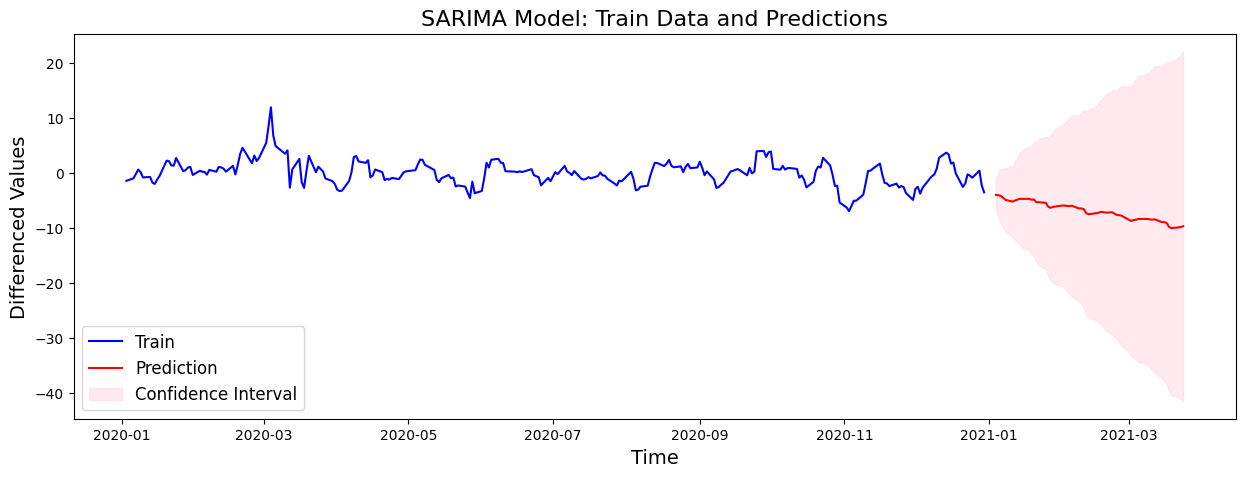

In [69]:
plt.figure(figsize=(15, 5))

# Plot the training data
plt.plot(df_train['rolling_mean_diff'], label='Train', color='blue')

# Plot the forecasted values from SARIMA
plt.plot(future_cast['rolling_mean_diff'], color='red', label='Prediction')

# Plot the confidence intervals
plt.fill_between(
    future_cast.index,
    future_cast['Lower_Band'],
    future_cast['Upper_Band'],
    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)

# Add title, labels, and legend
plt.title('SARIMA Model: Train Data and Predictions', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.show()


In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def evaluate_sarima_model(data, sarima_order, seasonal_order, start_train_size):
    """
    Evaluates a SARIMA model on a given dataset.

    Parameters:
    - data: The time series data.
    - sarima_order: Tuple for (p, d, q) for SARIMA.
    - seasonal_order: Tuple for (P, D, Q, S) for SARIMA seasonal components.
    - start_train_size: The initial size of the training set.

    Returns:
    - mse: Mean Squared Error.
    - mae: Mean Absolute Error.
    - predictions: List of predictions.
    """
    # Split the data into training history and testing set
    history = list(data[:start_train_size])
    predictions = []

    # Walk-forward validation for SARIMA
    for t in range(start_train_size, len(data)):
        # Fit SARIMA model
        model = SARIMAX(
            history,
            order=sarima_order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        # Forecast the next point
        future = model_fit.forecast(steps=1)[0]
        predictions.append(future)

        # Add the actual value to the history for the next iteration
        history.append(data[t])

    # Calculate evaluation metrics
    mse = mean_squared_error(data[start_train_size:], predictions)
    mae = mean_absolute_error(data[start_train_size:], predictions)

    return mse, mae, predictions


In [71]:
# Define SARIMA orders
sarima_order = (1, 2, 1)  # (p, d, q)
seasonal_order = (1, 1, 1, 12)  # (P, D, Q, S), assuming seasonality period = 12 (e.g., monthly data)

# Evaluate the SARIMA model
mse, mae, predictions = evaluate_sarima_model(
    df['rolling_mean_diff'].sort_index().values,  # Use sorted and numerical data
    sarima_order,
    seasonal_order,
    len(df_train)  # Start training size
)

# Print the results
print(f"MSE: {mse}, MAE: {mae}")


MSE: 1.4791044681923613, MAE: 0.9820844425862454


In [72]:
# Convert SARIMA predictions into a DataFrame
forecast = pd.DataFrame(predictions, columns=['rolling_mean_diff'])

# Ensure the forecast index matches the test set index
forecast.index = df_test.index

# Display the first few rows of the forecast DataFrame
forecast.head()


,rolling_mean_diff
Date,
2021-01-04,-4.020003
2021-01-05,-3.601165
2021-01-06,-1.788400
2021-01-08,-3.042605
2021-01-11,0.929160


In [73]:
f_std = forecast['rolling_mean_diff'].std()

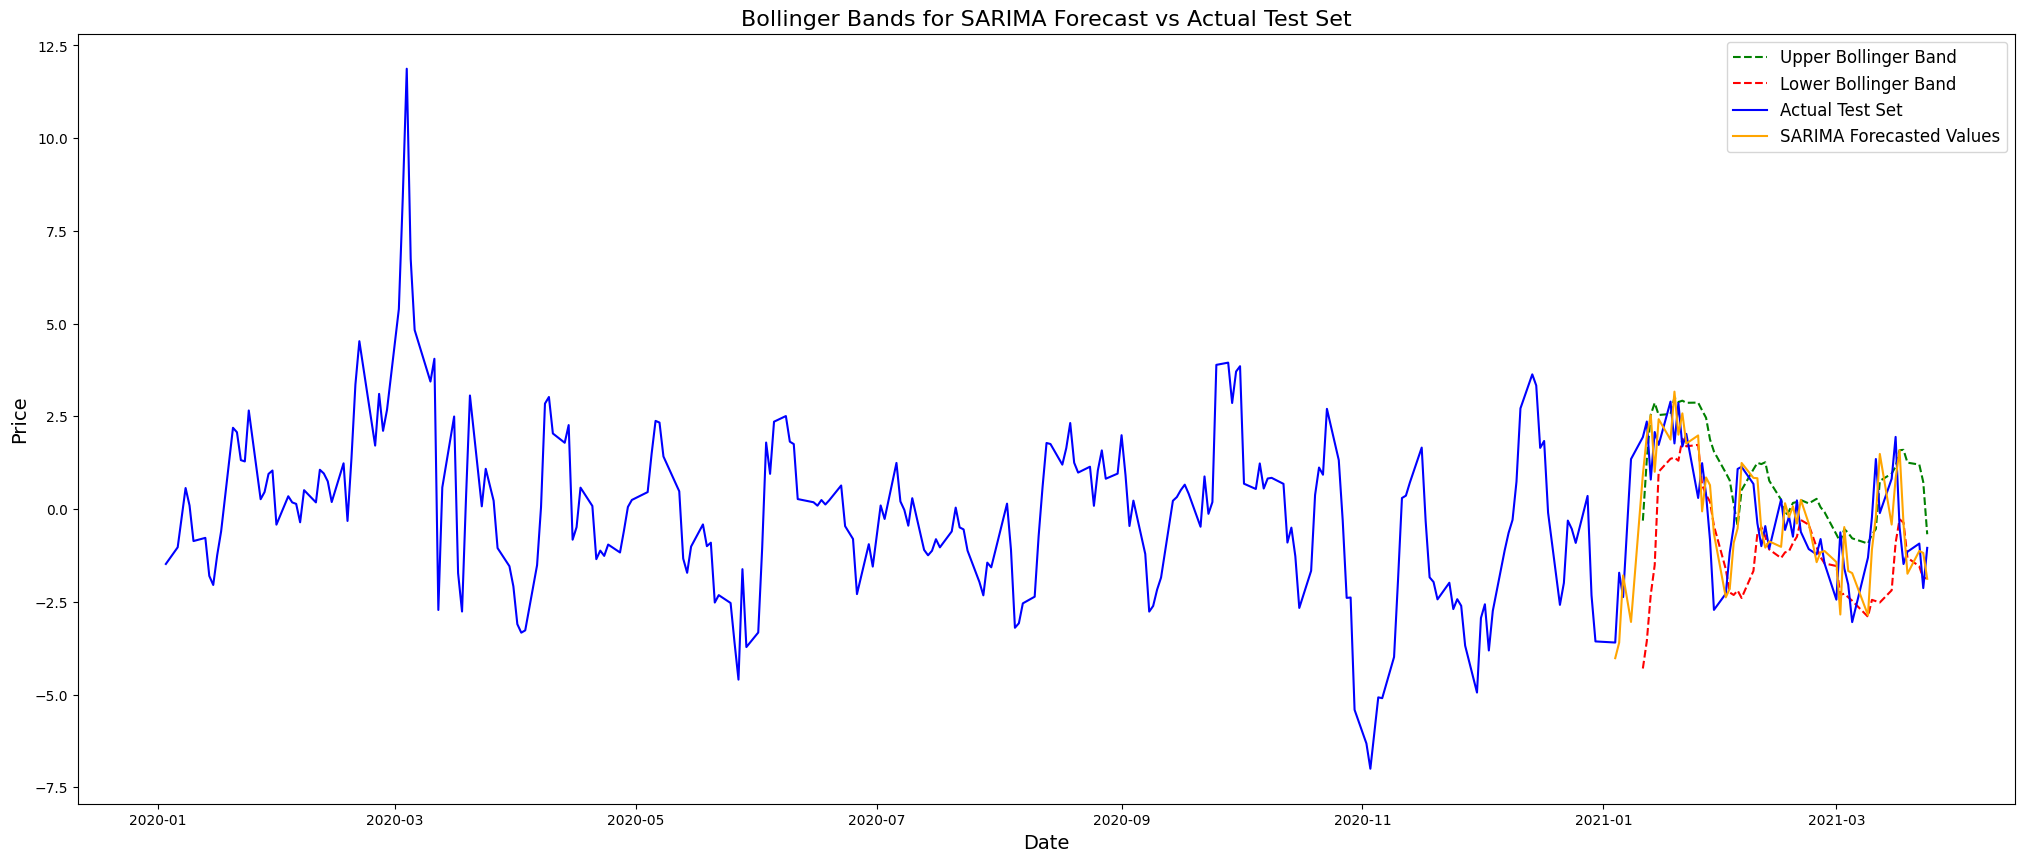

In [74]:
# Ensure that the 'rolling_mean_diff' in the forecast corresponds to SARIMA predictions
# Calculate Bollinger Bands for the SARIMA forecast
window = 5  # Rolling window size for Bollinger Bands
forecast['SMA'] = forecast['rolling_mean_diff'].rolling(window=window).mean()
forecast['Rolling_STD'] = forecast['rolling_mean_diff'].rolling(window=window).std()

# Upper and Lower Bands
forecast['Upper_Band'] = forecast['SMA'] + (forecast['Rolling_STD'])
forecast['Lower_Band'] = forecast['SMA'] - (forecast['Rolling_STD'])

# Plotting Bollinger Bands for the SARIMA forecast
plt.figure(figsize=(25, 10))

# Upper and Lower Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Actual test set
plt.plot(df['rolling_mean_diff'], label='Actual Test Set', color='blue')

# SARIMA Forecasted values
plt.plot(forecast['rolling_mean_diff'], label='SARIMA Forecasted Values', color='orange')

# Title and labels
plt.title('Bollinger Bands for SARIMA Forecast vs Actual Test Set', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.show()


            rolling_mean_diff  Upper_Band  Lower_Band Decision
Date                                                          
2021-01-04          -4.020003         NaN         NaN     Hold
2021-01-05          -3.601165         NaN         NaN     Hold
2021-01-06          -1.788400         NaN         NaN     Hold
2021-01-08          -3.042605         NaN         NaN     Hold
2021-01-11           0.929160   -0.311364   -4.297842     Sell
2021-01-12           1.964821    1.342554   -3.557830     Sell
2021-01-13           2.533165    2.544384   -2.305928     Hold
2021-01-14           1.005514    2.863806   -1.507784     Hold
2021-01-15           2.423577    2.535934    1.006561     Hold
2021-01-18           1.873197    2.564625    1.355484     Hold
2021-01-19           3.165920    3.010766    1.389783     Sell
2021-01-20           2.005886    2.885222    1.304415     Hold
2021-01-21           2.580175    2.922592    1.896910     Hold
2021-01-22           1.766479    2.865545    1.691118  

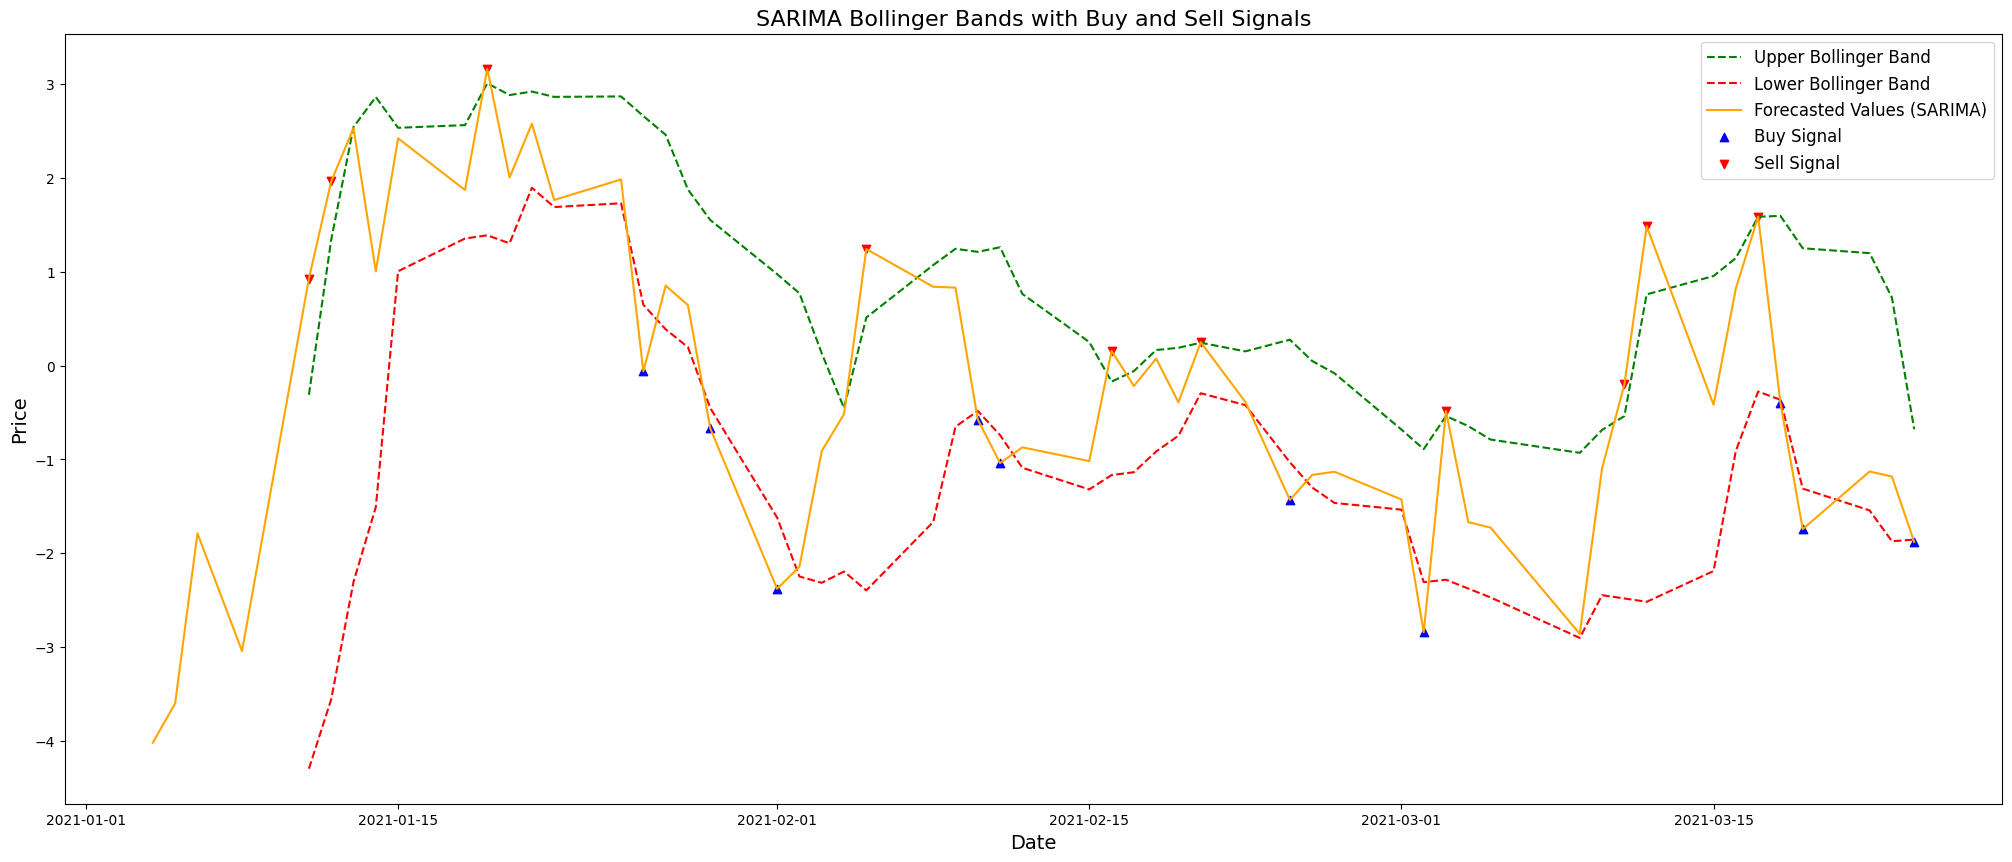

In [75]:
# Create a decision column for SARIMA forecast
forecast['Decision'] = 'Hold'

# Set Buy, Sell, or Hold based on Bollinger Bands
for i in range(len(forecast)):
    if forecast['rolling_mean_diff'].iloc[i] < forecast['Lower_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Buy'
    elif forecast['rolling_mean_diff'].iloc[i] > forecast['Upper_Band'].iloc[i]:
        forecast.loc[forecast.index[i], 'Decision'] = 'Sell'
    else:
        forecast.loc[forecast.index[i], 'Decision'] = 'Hold'

# Display the last few rows with decisions
print(forecast[['rolling_mean_diff', 'Upper_Band', 'Lower_Band', 'Decision']])

# Plotting decisions for SARIMA forecast
plt.figure(figsize=(25, 10))

# Plot Bollinger Bands
plt.plot(forecast['Upper_Band'], label='Upper Bollinger Band', color='green', linestyle='--')
plt.plot(forecast['Lower_Band'], label='Lower Bollinger Band', color='red', linestyle='--')

# Plot SARIMA forecasted values
plt.plot(forecast['rolling_mean_diff'], label='Forecasted Values (SARIMA)', color='orange')

# Highlight Buy and Sell points
buy_signals = forecast[forecast['Decision'] == 'Buy']
sell_signals = forecast[forecast['Decision'] == 'Sell']

plt.scatter(buy_signals.index, buy_signals['rolling_mean_diff'], label='Buy Signal', color='blue', marker='^', alpha=1)
plt.scatter(sell_signals.index, sell_signals['rolling_mean_diff'], label='Sell Signal', color='red', marker='v', alpha=1)

# Title and labels
plt.title('SARIMA Bollinger Bands with Buy and Sell Signals', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.show()


#Creating The prophet Model

In [90]:
# Ensure 'ds' column is in datetime format
df_train['ds'] = pd.to_datetime(df_train.index)  # Assuming your DataFrame index is the date
df_train.reset_index(drop=True, inplace=True)  # Reset index to avoid conflicts

# Rename columns for Prophet compatibility
df_train_prophet = df_train.rename(columns={'ds': 'ds', 'rolling_mean_diff': 'y'})


In [91]:
# Prepare future dates for forecasting
future_dates = pd.date_range(start=df_train_prophet['ds'].iloc[-1], periods=30, freq='D')
future_df = pd.DataFrame({'ds': future_dates})


In [92]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

def evaluate_prophet_model(data):
    # Prepare the data in Prophet-compatible format
    train = data.loc['2020-01-01':'2021-01-01']
    test = data.loc['2021-01-01':]

    train_prophet = train.reset_index().rename(columns={'index': 'ds', 'rolling_mean_diff': 'y'})
    test_prophet = test.reset_index()

    # Initialize the Prophet model
    model = Prophet()
    model.fit(train_prophet)

    # Create a future dataframe for forecasting
    future = model.make_future_dataframe(periods=len(test), freq='D')
    forecast = model.predict(future)

    # Extract the forecasted values for the test period
    predictions = forecast[-len(test):]['yhat'].values

    # Calculate the error
    error = mean_squared_error(test['rolling_mean_diff'].values, predictions)

    return error, predictions


In [93]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

def evaluate_prophet_model(data):
    best_score = float("inf")
    best_model = None
    predictions = None

    # Prepare the data in Prophet-compatible format
    train = data.loc['2020-01-01':'2021-01-01']
    test = data.loc['2021-01-01':]

    train_prophet = train.reset_index().rename(columns={'index': 'ds', 'rolling_mean_diff': 'y'})
    test_prophet = test.reset_index()

    try:
        # Initialize and fit the Prophet model
        model = Prophet()
        model.fit(train_prophet)

        # Create a future dataframe for forecasting
        future = model.make_future_dataframe(periods=len(test), freq='D')
        forecast = model.predict(future)

        # Extract forecasted values for the test period
        predicted_values = forecast[-len(test):]['yhat'].values

        # Calculate the Mean Squared Error
        mse = mean_squared_error(test['rolling_mean_diff'].values, predicted_values)

        # Store the best model and predictions if it improves the score
        if mse < best_score:
            best_score = mse
            best_model = model
            predictions = predicted_values

        print(f'Prophet Model MSE={mse:.3f}')
    except Exception as e:
        print(f"Error occurred: {e}")

    return best_model, best_score, predictions


In [95]:
from prophet import Prophet

# Prepare data for Prophet
df_train['ds'] = pd.to_datetime(df_train.index)  # Convert index to datetime
df_train_prophet = df_train.reset_index(drop=True).rename(columns={'rolling_mean_diff': 'y'})

# Fit the model
model = Prophet()
model.fit(df_train_prophet)

# Make future predictions
future_dates = model.make_future_dataframe(periods=30)
forecast = model.predict(future_dates)

# Check forecasted dates
print(forecast[['ds', 'yhat']].head())


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_p1sca2/zgib83i2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa_p1sca2/g4f3wkhy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20115', 'data', 'file=/tmp/tmpa_p1sca2/zgib83i2.json', 'init=/tmp/tmpa_p1sca2/g4f3wkhy.json', 'output', 'file=/tmp/tmpa_p1sca2/prophet_modeljw8v2_rg/prophet_model-20250128064423.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:44:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:44:23 - cmdstanpy - INFO - Chain

                             ds      yhat
0 1970-01-01 00:00:00.000000000  0.785378
1 1970-01-01 00:00:00.000000001  0.778907
2 1970-01-01 00:00:00.000000002  0.772436
3 1970-01-01 00:00:00.000000003  0.765964
4 1970-01-01 00:00:00.000000004  0.759493


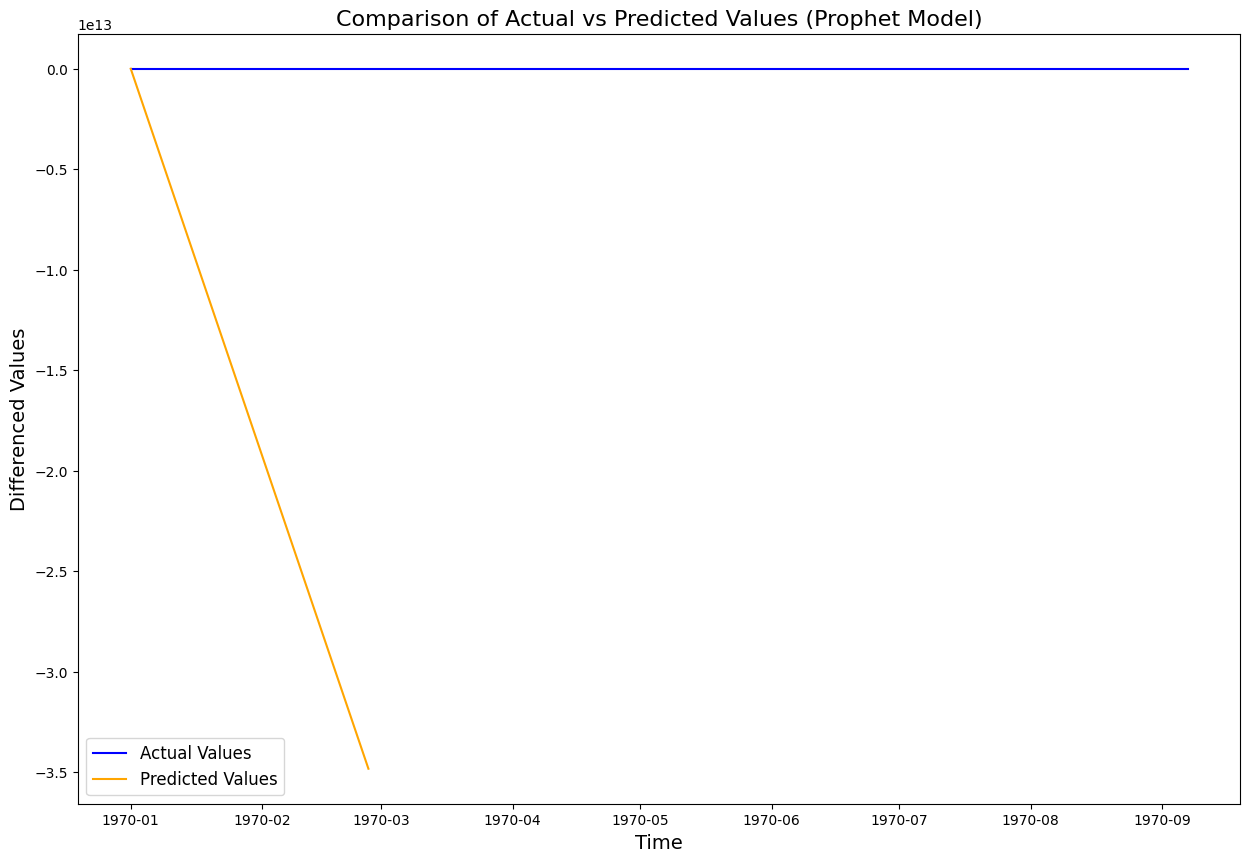

In [84]:
import matplotlib.pyplot as plt

# Ensure 'ds' is a datetime index and 'yhat' contains predicted values
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Plot the comparison of actual and predicted values
plt.figure(figsize=(15, 10))

# Plot the actual values
plt.plot(df_train['rolling_mean_diff'], label='Actual Values', color='blue')

# Plot the Prophet model's predictions
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Values', color='orange')

# Add title and labels
plt.title('Comparison of Actual vs Predicted Values (Prophet Model)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()


In [85]:
# Create a future dataframe for forecasting
future = model.make_future_dataframe(periods=len(df_test), freq='D')

# Generate the forecast
forecast = model.predict(future)

# Select only the forecasted values corresponding to the test set period
future_cast = forecast[['ds', 'yhat']].iloc[-len(df_test):]  # Extract forecast for the test set
future_cast.index = df_test.index  # Align index with the test set

# Rename the columns for consistency
future_cast = future_cast.rename(columns={'yhat': 'rolling_mean_diff'})

# Display the first few rows of the forecast
print(future_cast.head())


                                      ds  rolling_mean_diff
Date                                                       
2021-01-04 1970-01-02 00:00:00.000000249      -6.218463e+11
2021-01-05 1970-01-03 00:00:00.000000249      -1.243693e+12
2021-01-06 1970-01-04 00:00:00.000000249      -1.865539e+12
2021-01-08 1970-01-05 00:00:00.000000249      -2.487385e+12
2021-01-11 1970-01-06 00:00:00.000000249      -3.109231e+12


In [87]:
# Prepare data for Prophet
df_train_prophet = df_train.reset_index()  # Ensure 'index' is part of the DataFrame
df_train_prophet.rename(columns={'index': 'ds', 'rolling_mean_diff': 'y'}, inplace=True)
future_cast_prophet = future_cast.reset_index()
future_cast_prophet.rename(columns={'index': 'ds', 'rolling_mean_diff': 'y'}, inplace=True)


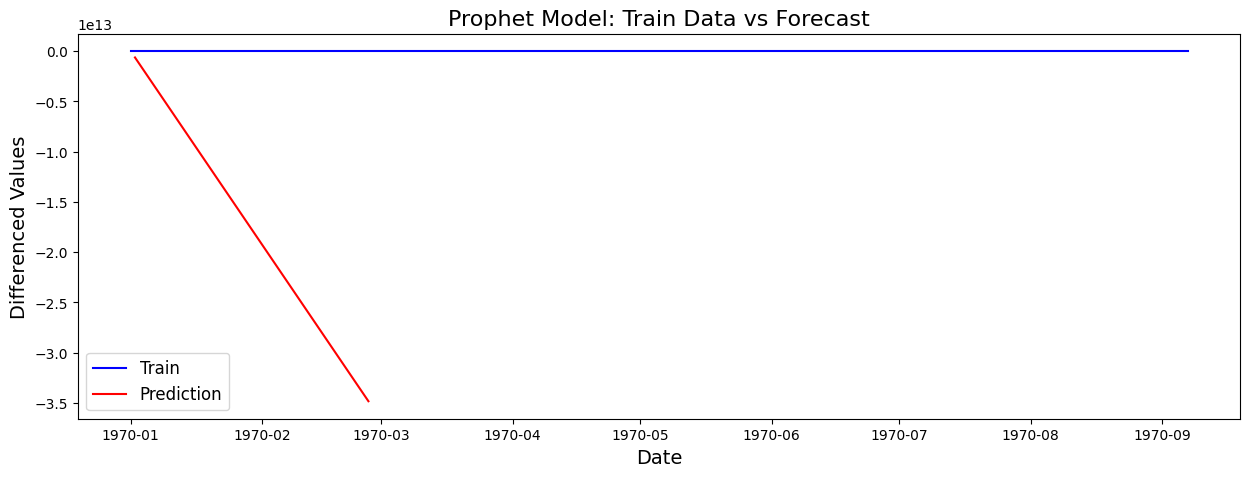

In [89]:
plt.figure(figsize=(15, 5))

# Plot the training data
plt.plot(df_train_prophet['ds'], df_train_prophet['y'], label='Train', color='blue')

# Plot the Prophet model's predictions
plt.plot(future_cast_prophet['ds'], future_cast_prophet['y'], color='red', label='Prediction')

# Add title, labels, and legend
plt.title('Prophet Model: Train Data vs Forecast', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.show()


#Creating The LSTM Model

In [96]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

def evaluate_lstm_model(data, time_steps=10, epochs=50, batch_size=16):
    # Preprocessing
    train = data.loc['2020-01-01':'2021-01-01']['rolling_mean_diff'].values
    test = data.loc['2021-01-01':]['rolling_mean_diff'].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train.reshape(-1, 1))
    test_scaled = scaler.transform(test.reshape(-1, 1))

    # Create datasets for LSTM
    X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
    X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

    # Reshape input to [samples, time_steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, activation='relu', input_shape=(time_steps, 1)),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform predictions and test data
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test)

    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)

    return mse, predictions, y_test



In [97]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np

# Scale the data
data_scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = data_scaler.fit_transform(df_train['rolling_mean_diff'].values.reshape(-1, 1))

def create_lstm_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Define parameters
time_steps = 10

# Create LSTM datasets
X_train, y_train = create_lstm_dataset(data_scaled, time_steps)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Prepare test data
data_test_scaled = data_scaler.transform(df_test['rolling_mean_diff'].values.reshape(-1, 1))
X_test, _ = create_lstm_dataset(data_test_scaled, time_steps)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Forecasting
forecast_scaled = model.predict(X_test)
forecast = data_scaler.inverse_transform(forecast_scaled)

# Prepare forecast DataFrame
forecast_df = pd.DataFrame(forecast, columns=['rolling_mean_diff'])
forecast_df.index = df_test.index[time_steps:]  # Align indices with the test set

print(forecast_df.head())


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.1278
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1030
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0731
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0351
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0165
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0192
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0127
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0134
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0146
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0146
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0129
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0163
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0148
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━

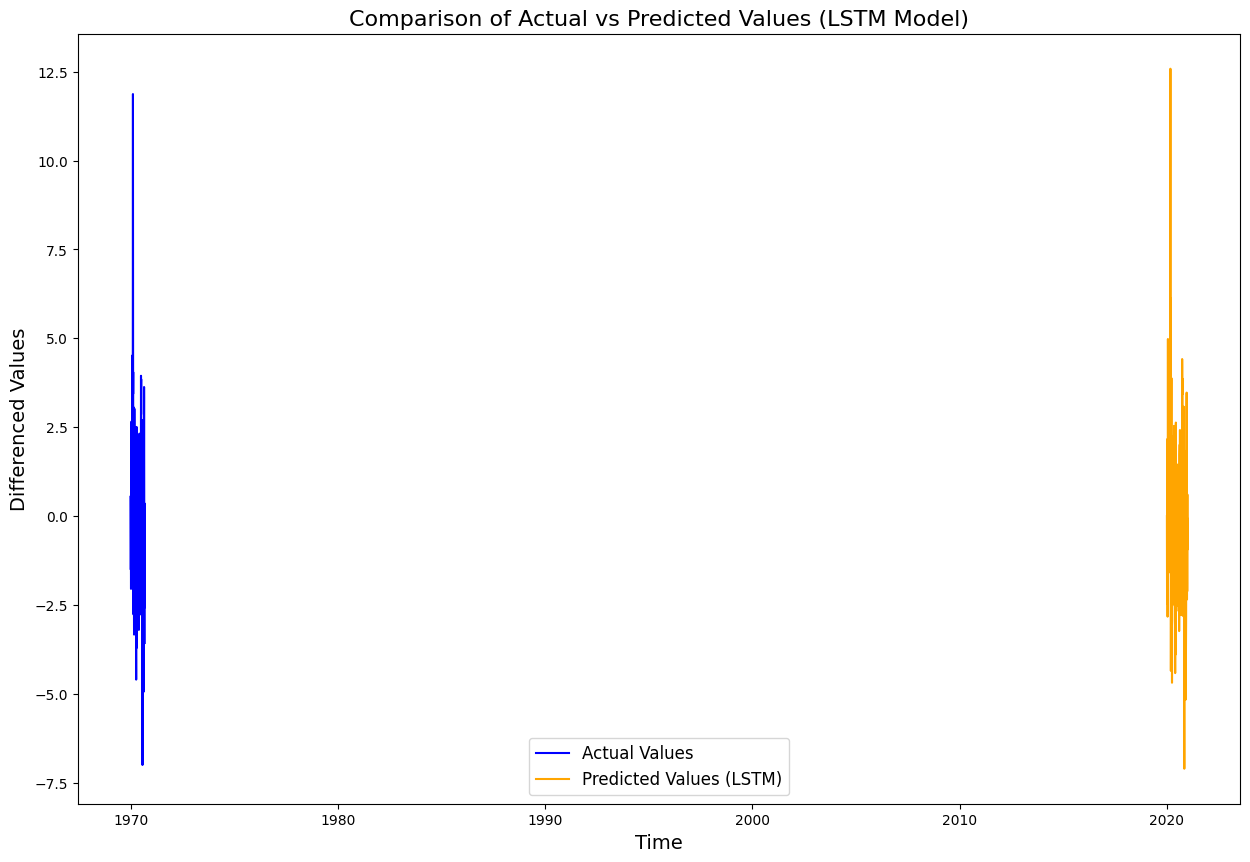

In [99]:
# Ensure the predicted values are correctly referenced
plt.figure(figsize=(15, 10))

# Plot the actual values from the training data
plt.plot(df_train['rolling_mean_diff'], label='Actual Values', color='blue')

# Plot the LSTM model's predictions
plt.plot(predicted_values, label='Predicted Values (LSTM)', color='orange')

# Add title and labels
plt.title('Comparison of Actual vs Predicted Values (LSTM Model)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Differenced Values', fontsize=14)

# Add a legend
plt.legend(fontsize=12)

# Display the plot
plt.show()
